## Circuit packers

In this notebook, we explore packers that the parallelizer provides. If you are not familiar with
the parallelizer on a basic level, see the
[introductory notebook](./parallel-circuits-introduction.ipynb).

In [1]:
import iqm.qiskit_iqm as iqm
import qc_parallelizer as parallelizer
import qiskit
from iqm.qiskit_iqm import IQMFakeAphrodite
from qc_parallelizer import base, circuitbin, packers

backend = IQMFakeAphrodite()
print(backend.num_qubits, "qubits available.")

54 qubits available.


As an example, we will consider 18 five-qubit star-shaped circuits. The 54-qubit backend happens to
allow nine such circuits to be placed in parallel, so there should be exactly two jobs required to
run all circuits.

In [2]:
def build_ghz_circuit(n: int):
    circuit = qiskit.QuantumCircuit(n)
    circuit.h(0)
    circuit.cx(0, list(range(1, n)))
    return circuit


circuits = [build_ghz_circuit(5) for i in range(9 * 2)]

### Default packer

Let's check what happens if we use the default packer. For convenience, we will define a function
that lets us easily test different packers.

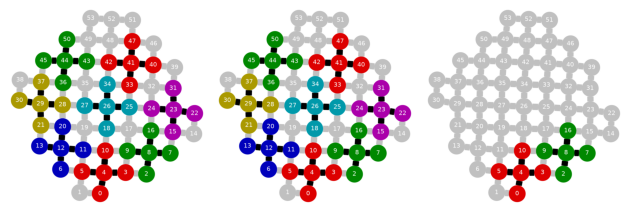

In [3]:
def plot_packing(**kwargs):
    parallelized = parallelizer.rearrange(
        circuits,
        backend,
        **kwargs,
    )
    return parallelizer.visualization.plot_placements(parallelized)


plot_packing()

Hmm &mdash; decently dense, but not optimal.

The default packer is `packers.Defaults.Fast`, which currently evaluates to...

In [4]:
print(packers.Defaults.Fast)
print(packers.Defaults.Fast.__doc__.strip())

<class 'qc_parallelizer.packers.VF2Packers.NonOptimizing'>
Finds any valid layout. Very efficient, but results in possibly non-optimal packings.


Aha! Indeed, the packer is very fast (taking only 0.6s on a quad core mobile Core i7 for all 18
circuits), but the packing is not optimal. What options do we have?

### Available packers

The `packers` module currently defines two general classes of packers: `SMTPackers` and
`VF2Packers`:

In [5]:
print("SMTPackers:", packers.SMTPackers.__doc__.strip())
print("VF2Packers:", packers.VF2Packers.__doc__.strip())

SMTPackers: A collection of packers that use the Z3 SMT solver/optimizer to determine layouts.
VF2Packers: A collection of packers that utilize the VF2++ layout algorithm.


(If you're not familiar with some of the abbreviations above, see
[Z3](https://github.com/Z3Prover/z3) /
[SMT](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories) and
[VF2++](https://www.sciencedirect.com/science/article/pii/S0166218X18300829). Simply put, they are
different algorithms/techniques for determining circuit layouts.)

Both provide a `NonOptimizing` packer, which should be the fastest to execute in each class.
Additionally, the packers provide optimizing versions, which attempt to generate denser packings at
the cost of longer packing times. Currently, there are three options:
- `SMTPackers.Minimizing`: This packer uses an SMT solver combined with a cost function that is
  computed from the number of couplers that a circuit placement requires (including couplers at the
  edges of the circuit that connect to qubits outside the circuit).
- `SMTPackers.SoftConstraining`: Similar to the above, but uses "soft constraints" or penalties for
  each of the backend's qubits with the penalty being proportional to how many couplers the qubit
  connects to. This should result in the same packing as the `Minimizing` version, but with
  different computational cost.
- `VF2Packers.Minimizing`: Iterates different results of the VF2++ algorithm and picks the best
  option. For circuits that have very "rigid" topologies (such as grids, as opposed to linear), the
  VF2++ algorithm is fast, so iterating over all solutions is also relatively efficient. This is
  aliased as `Defaults.Optimizing`.

Let's try these out!

#### Non-optimizing SMT packer

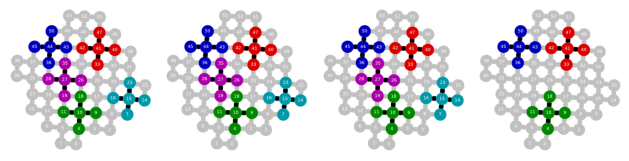

In [6]:
plot_packing(packer=packers.SMTPackers.NonOptimizing())

This is quite poor in many regards, but there is an example at the end of this notebook that
highlights a case where this packer shines.

#### Minimizing SMT packer

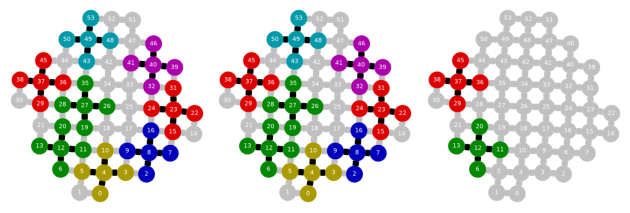

In [7]:
plot_packing(packer=packers.SMTPackers.Minimizing(seed=1))

#### Soft-constraining/penalizing SMT packer

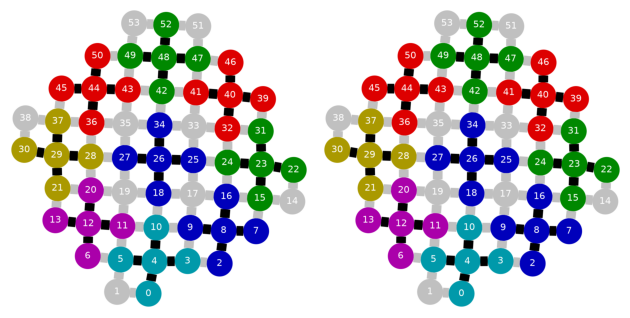

In [8]:
plot_packing(packer=packers.SMTPackers.SoftConstraining(seed=1))

This is one example of an optimal packing. However, this packer can also generate worse packings
with different seeds, and there is a faster packer that achieves the same density more consistently
&mdash; see below.

#### Non-optimizing VF2++ packer (fast default)

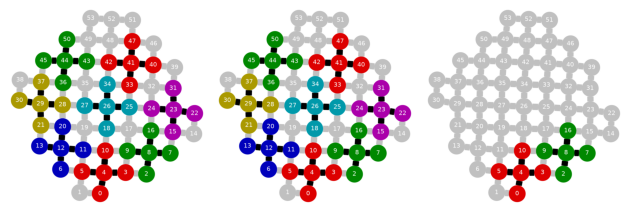

In [9]:
plot_packing(packer=packers.VF2Packers.NonOptimizing())

#### Minimizing VF2++ packer (optimizing default)

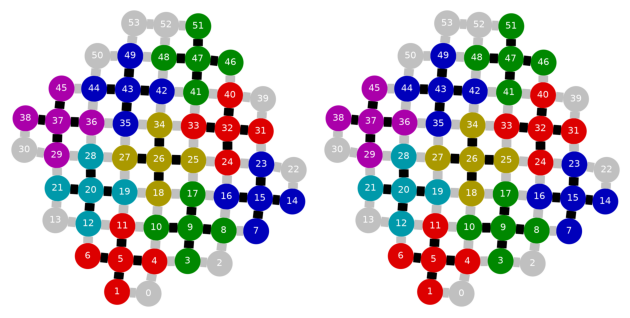

In [10]:
plot_packing(packer=packers.VF2Packers.Minimizing())

Another optimal packing.

Essentially, there are two things to consider in each option: **packing density** and **execution
time**. The defaults are what they are since they seem to yield good results in many cases, but if
you find that some other packer performs better in your application, use it!

In addition to providing different algorithms, you can also control internal options, or define your
own packers entirely. More on the latter later.

### Packer parameters

There are various options in each packer that would have caused a combinatorial explosion if a
separate class existed for all versions. Instead, the packer constructors accept a varying number
of keywords arguments to set these options. Sensible defaults also exist, so no parameters have to
be defined.

The `PackerBase` class defines four general arguments:

In [11]:
packers.PackerBase.__init__?

Signature:
packers.PackerBase.__init__(
    self,
    min_intra_distance: int = 0,
    min_inter_distance: int = 0,
    max_bins_per_backend: int | None = None,
    max_candidates: int | None = 1,
)
Docstring:
Args:
    min_intra_distance:
        Sets the minimum distance between physical placements of two qubits **from the same
        circuit** that do not share any gates. If 0, circuits can be packed as densely as
        possible. If 1, qubits can be placed next to each other only if they share gates.
        Other values are currently not supported.
    min_inter_distance:
        Sets the minimum distance between physical placements of two qubits **from different
        circuits**. Setting this to 0 achieves the densest packing, but may introduce
        unwanted crosstalk. Setting this to 1 forces "padding" qubits to be left between
        circuits. Greater values are also accepted, but possibly with diminishing returns.
    max_bins_per_backend:
        Controls how many bin

There's a bit to unpack here, but in summary:
- `min_intra_distance`: minimum distance between non-coupling qubits of the same circuit
- `min_inter_distance`: minimum distance between non-coupling qubits of different circuits
- `max_bins_per_backend`: how many "bins" or host circuits can be run sequentially per backend
- `max_candidates`: how many backend bin candidates should be considered before picking an optimum

Probably the most useful feature is `min_inter_distance`. By default, it is zero, which allows
circuits to be placed right next to each other. However, this might introduce noise from crosstalk.

A solution is to space the circuits out with "padding" qubits, which can be achieved by setting
`min_inter_distance` to 1. Let's try that with the default packer. (It won't help us reach our
goal &mdash; in fact, it will take us further from it &mdash; but it's a good demonstration.)

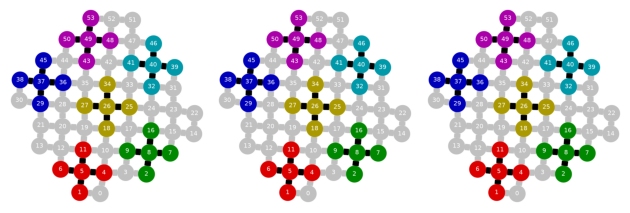

In [12]:
plot_packing(packer=packers.Defaults.Optimizing(min_inter_distance=1))

Indeed, no two circuits touch each other now. Of course, this results in much lower density, but in
some cases it might be worth it.

In addition to the parameters above, the packer implementations also have their own specific
parameters:
- All `SMTPackers` as well as `VF2Packers.Minimizing` take a `timeout` keyword argument. This sets
  the maximum runtime for the algorithms in milliseconds. The default is 2000 ms, and the timeout
  can be disabled completely by setting it to None.
- All `VF2Packers` take a `seed` argument, which seeds the underlying call to Z3. By default, the
  seed is fixed, but other values may be passed to alter results. In some cases, a good seed can
  also significantly reduce execution times. 
- All `VF2Packers` take the following arguments:
  - `id_order`: controls the order that nodes (qubits) are evaluated in; if True, they are processed
    in order, if False, they are considered with a heuristic matching order (as defined in the VF2++
    paper, see that for more details).
  - `call_limit`: limits the number of states that the algorithm explores internally.

Let us consider the `id_order` parameter for example. By default, it is False, so a heuristic
matching order is used. Let's set it to True, and see what happens:

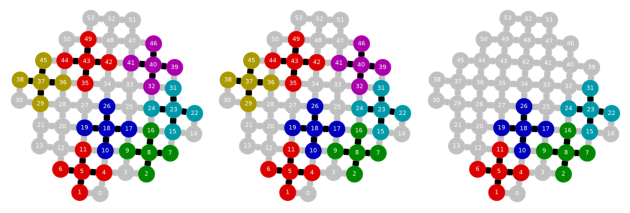

In [13]:
plot_packing(packer=packers.VF2Packers.Minimizing(id_order=True))

This is much worse than with heuristic ordering. However, some applications may benefit from it.
So, experimentation is recommended.

### Custom packers

If you find yourself in need of a custom algorithm for determining layouts or restricting which
qubits can be used or not, you may extend either the `PackerBase` class or any of the packer
implementations to create your own.

For example, let's say that we want each row of qubits in the backend to allow only one circuit.
That is, if a circuit uses qubits from rows 3, 4 and 5, then no other circuit may use qubits from
those rows. For this, we will need a table of which qubits belong to which row.

> In this case, a "row" refers to a set of qubits in the backend that are all horirontally adjacent
  to each other. This does depend on how you orient the backend, but here, we consider the
  orientation that the figures use.

In [14]:
row_widths = [2, 5, 7, 8, 9, 8, 7, 5, 3]
assert sum(row_widths) == 54
row = 0
row_qbs: dict[int, set[int]] = {row: set() for row in range(len(row_widths))}
for qb in range(54):
    row_qbs[row].add(qb)
    if len(row_qbs[row]) == row_widths[row]:
        row += 1
qb_rows: dict[int, int] = {}
for row, qbs in row_qbs.items():
    for qb in qbs:
        qb_rows[qb] = row

# We now have two tables: `row_qbs` tells us which qubits are in a given row, and `qb_rows` tells us
# which row a given qubit belongs to.

Then, we will define our own packer as an extension of the default fast packer. We will override the
`blocked()` method, whose role is to tell the parallelizer which qubits cannot be used in the
current state of the packing. Note that this method _must_ return a superset of the bin's currently
taken indices.

It takes one argument, a `CircuitBin` object, which represents a single circuit "bin". Bins are
instances of backend-wide circuits that contain the circuits that are then packed into one job for
that backend. The bin objects provide many convenient properties, but here, we only care about which
qubit indices have already been taken in the bin.

In [15]:
class MutuallyExclusiveRowsPacker(packers.Defaults.Fast):
    def blocked(self, bin: circuitbin.CircuitBin):
        # First, we will grab the indices that are in use currently.
        used_qubits = bin.taken_indices
        # Then, we will "smear" them horizontally, so that qubits in rows that have at least one
        # used qubit are all marked as blocked. Note that since we work with sets, we do not care
        # about adding duplicates.
        smeared = used_qubits.copy()
        for qb in used_qubits:
            qubits_in_row = row_qbs[qb_rows[qb]]
            smeared |= qubits_in_row
        # And finally, we simply return the new set.
        return smeared

That's everything we need! Now we can pass the custom packer to the parallelizer and see if it
works...

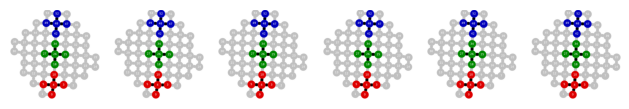

In [16]:
plot_packing(packer=MutuallyExclusiveRowsPacker())

Looks correct - each row of the backend is occupied by only one circuit.

This is a made up example, of course &mdash; but it shows how you can quite easily implement
whatever logic you need. For more information on what other behaviour can be customized, see the
`packers` module and the docstrings in the `PackerBase` class in particular.

### Conclusion

The above should be a quite high-level overview of how packing behaviour can be controlled. Some
methods also utilize randomness, so you may have different results yourself. In general, if the
defaults work, use them. If they don't, experiment to see what does.

To finish, below is an example that demonstrates why the defaults are not always the best. In fact,
the defaults don't work at all here.

VF2++ failed!


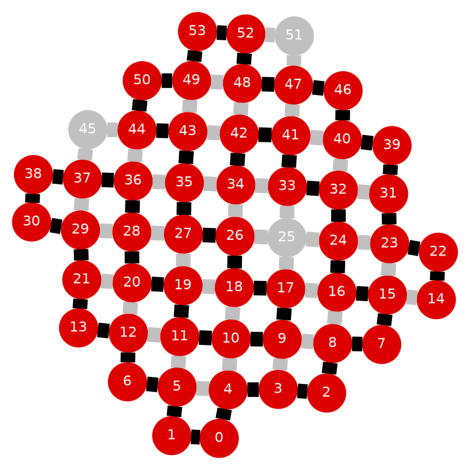

In [17]:
def create_linear_circuit(n: int):
    circuit = qiskit.QuantumCircuit(n)
    circuit.h(0)
    for i in range(n - 1):
        circuit.cx(i, i + 1)
    return circuit


snake = create_linear_circuit(51)
# We now have a 50-qubit circuit with a linear topology. Each qubit needs to couple with the
# surrounding qubits only, creating a long chain.

# This does not find a solution! The call limit has been decreased here, but even with higher
# limits, it would take _very_ long.
try:
    snake = parallelizer.rearrange(
        [snake], backend, packer=packers.VF2Packers.NonOptimizing(call_limit=1_000_000)
    )
except base.Exceptions.CircuitBackendCompatibility:
    print("VF2++ failed!")

# Instead... (with a preselected seed that happens to perform very well)
snake = parallelizer.rearrange(
    [snake], backend, packer=packers.SMTPackers.NonOptimizing(seed=3, timeout=8000, max_attempts=8)
)
parallelizer.visualization.plot_placements(snake)